In this notebook I used cleaned data for human-written real and fake jobs. The main purpose of this notebook is to check if scammers usually target certain departments, along with the corresponding salaries for both real and fake jobs.

The columns used to detect this are job title, department, industry, and function. They all relate to the same point, only in different columns and wordings! 

I used clustering to gather all four columns into specific set of clusters, since the wording among four columns is different, but they refer to the same meanings. Used sentence transformers for this to convert text into numerical vectors ("embeddings") in order to catch the semantic meanings of texts.

The main goal of this is to detect the elements that scammers tend to do/use before feeding their text INto LLMs for refinement, and to compare those element with real jobs. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
import re
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.patches as mpatches
import hdbscan

In [ ]:
real_df = pd.read_csv("../1_datasets/cleaned_data/real_jobs.csv", keep_default_na=False)  # noqa: E501
fake_df = pd.read_csv("../1_datasets/cleaned_data/fake_jobs.csv", keep_default_na=False)  # noqa: E501

print("Shape of the real jobs dataset:", real_df.shape)
print("Shape of the fake jobs dataset:", fake_df.shape)
print()

real_jobs = real_df[
    [
        "title",
        "department",
        "industry",
        "function",
        "salary_range",
        "fraudulent",
    ]
]
fake_jobs = fake_df[
    [
        "title",
        "department",
        "industry",
        "function",
        "salary_range",
        "fraudulent",
    ]
]

print(
    "Shape of real jobs dataset after excluding unnecessary columns:",
    real_jobs.shape,
)

print(
    "Shape of fake jobs dataset after excluding unnecessary columns:",
    fake_jobs.shape,
)

Shape of the real jobs dataset: (17014, 11)
Shape of the fake jobs dataset: (866, 11)

Shape of real jobs dataset after excluding unnecessary columns: (17014, 6)
Shape of fake jobs dataset after excluding unnecessary columns: (866, 6)


In [4]:
# Checking missing values
print(
    "Number of empty values in these columns in real jobs:\n",
    (real_jobs == "").sum(),
)

print()

print(
    "Number of empty values in these columns in fake jobs:\n",
    (fake_jobs == "").sum(),
)

Number of empty values in these columns in real jobs:
 title               0
department      11022
industry         4628
function         6118
salary_range    14369
fraudulent          0
dtype: int64

Number of empty values in these columns in fake jobs:
 title             0
department      531
industry        275
function        337
salary_range    643
fraudulent        0
dtype: int64


The main reason for checking for empty values instead of NaN values is the fact that when I cleaned the dataset, I replaced all NaN values with empty strings. It was very tricky to decide which rows to drop since all team members are doing different analysis, and also since we're doing NLP, we can not have 'NaN' since it's a text, hence I replaced them all with empty strings in order to avoid any conflicts when doing NLP.

In [6]:
# merging the two datasets
combined_jobs = pd.concat([real_jobs, fake_jobs], ignore_index=True)

print(
    "Shape of the dataset after concatenating both real and fake jobs:",
    combined_jobs.shape,
)

Shape of the dataset after concatenating both real and fake jobs: (17880, 6)


In [7]:
def cleaned_salary_range(salary_str):
    salary_str = str(salary_str).lower()

    # checks if there's a digit in salary_str
    if not re.search(r"\d", salary_str):
        return ""

    try:
        # calculating the avg salary rate
        if "-" in salary_str:
            parts = salary_str.split("-")

            low = float(parts[0])
            high = float(parts[1])
            return (low + high) / 2

        else:
            return float(salary_str)

    except ValueError:
        return np.nan


# replacing the old salary range with the average
combined_jobs = combined_jobs.copy()

combined_jobs["salary_range"] = combined_jobs["salary_range"].apply(
    cleaned_salary_range
)  # noqa: E501

combined_jobs.head()

,title,department,industry,function,salary_range,fraudulent
0,Marketing Intern,Marketing,,Marketing,,0
1,Customer Service - Cloud Video Production,Success,Marketing and Advertising,Customer Service,,0
2,Commissioning Machinery Assistant (CMA),,,,,0
3,Account Executive - Washington DC,Sales,Computer Software,Sales,,0
4,Bill Review Manager,,Hospital & Health Care,Health Care Provider,,0


Label: 0, Count: 17014
Label: 1, Count: 866


<function matplotlib.pyplot.show(close=None, block=None)>

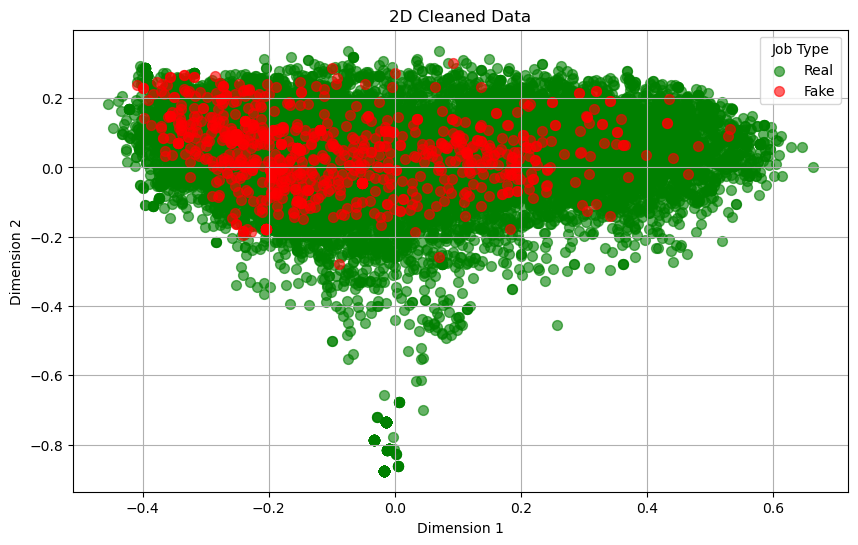

In [9]:
%matplotlib inline

# combining values across columns for each row
combined_jobs["job_text"] = combined_jobs[
    ["title", "department", "industry", "function"]
].agg(" ".join, axis=1)

combined_jobs["job_text"].str.lower().str.strip()

combined_jobs.drop(
    columns=["title", "department", "industry", "function"], inplace=True
)  # noqa: E501

# converting text into numerical vectors ("embeddings")
# catching the semantic meanings of texts
model = SentenceTransformer("all-mpnet-base-v2")
# model = SentenceTransformer("all-MiniLM-L6-v2")

# compare text based on meaning, not exact words
# changing pandas series to a list to work with .encode
embeddings = model.encode(combined_jobs["job_text"].tolist())

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embeddings)

label_map = {0: "Real", 1: "Fake"}

color_map = {0: "green", 1: "red"}

combined_jobs["pca_x"] = reduced_data[:, 0]
combined_jobs["pca_y"] = reduced_data[:, 1]

plt.figure(figsize=(10, 6))

for label, group in combined_jobs.groupby("fraudulent"):
    print(f"Label: {label}, Count: {len(group)}")
    plt.scatter(
        group["pca_x"],
        group["pca_y"],
        color=color_map[int(label)],
        s=50,
        alpha=0.6,
        label=label_map[int(label)],
    )

plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("2D Cleaned Data")
plt.legend(title="Job Type")
plt.grid(True)
plt.show

The main purpose of this graph is to see if some [titles, departments, function, industry] all which have been grouped into [job text] tend to appear more in fake jobs compared to real jobs. However, we can clearly see the major overlapping happening here! I think it's maybe due to the fact that the data is highly imbalanced with 95% of the raw dataset being real jobs in the first place. 

Since clustering is sensitive to imbalanced data, I thought of reducing the number of real jobs to match the number of fake jobs, apply clustering again, then check the graph.

Used hdbscan library to manage the overlapping since its performance exceeds Kmeans in this case.

c:\Users\alaaa\anaconda3\miniconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alaaa\anaconda3\miniconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


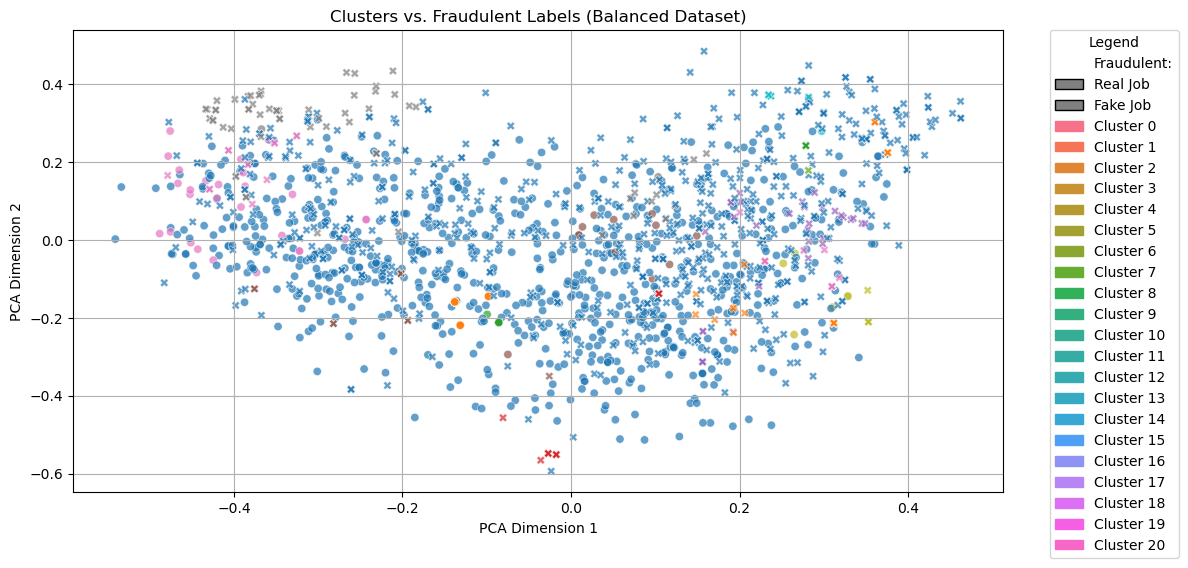

In [10]:
# sample 866 real jobs to match the 866 fake jobs
real_sample = combined_jobs[combined_jobs["fraudulent"] == 0].sample(
    n=866, random_state=42
)  # noqa: E501
fake_sample = combined_jobs[combined_jobs["fraudulent"] == 1]

balanced_jobs = pd.concat([real_sample, fake_sample], ignore_index=True)

# get embeddings and PCA only for balanced data
balanced_embeddings = model.encode(balanced_jobs["job_text"].tolist())
reduced_data = PCA(n_components=2).fit_transform(balanced_embeddings)

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, prediction_data=True)  # noqa: E501
hdb_clusters = clusterer.fit_predict(balanced_embeddings)

balanced_jobs["cluster"] = hdb_clusters
balanced_jobs["pca_x"] = reduced_data[:, 0]
balanced_jobs["pca_y"] = reduced_data[:, 1]

# print(balanced_jobs.groupby(["cluster", "fraudulent"]).size())

plt.figure(figsize=(12, 6))

palette = sns.color_palette("husl", len(balanced_jobs["cluster"].unique()))  # noqa: E501

clustered = balanced_jobs[balanced_jobs["cluster"] != -1]

sns.scatterplot(
    data=balanced_jobs,
    x="pca_x",
    y="pca_y",
    hue="cluster",  # color by cluster ID
    style="fraudulent",  # shape by real (0) or fake (1)
    palette="tab10",
    alpha=0.7,
    legend=False,
)

styles = {0: ("o", "Real Job"), 1: ("^", "Fake Job")}
fraud_legend = [
    mpatches.Patch(color="white", label="Fraudulent:"),
    *[
        mpatches.Patch(facecolor="gray", edgecolor="black", label=label)  # noqa: E501
        for _, label in styles.values()
    ],
]

# clusters (hue legend)
cluster_legend = [
    mpatches.Patch(color=palette[i], label=f"Cluster {c}")
    for i, c in enumerate(sorted(clustered["cluster"].unique()))
]

plt.legend(
    handles=fraud_legend + cluster_legend,
    title="Legend",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
)

plt.title("Clusters vs. Fraudulent Labels (Balanced Dataset)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
# plt.legend(title="Cluster / Fraud")
plt.grid(True)
plt.show()

We can see from the overlapping happening among clusters here is apparently job scammers try their luck with all sorts of jobs titles and departments! There isn't really specific departments which they usually tend to draw more attention to.

Now I'd like to see the salaries corresponding to each cluster among both real and fake jobs, to see if the theory saying "fake jobs promise the dream salaries" does exist.

In [ ]:
balanced_jobs["salary_range"] = pd.to_numeric(
    balanced_jobs["salary_range"], errors="coerce"
)

salary_stats = (
    balanced_jobs.groupby("cluster")["salary_range"]
    .agg(["count", "mean", "min", "max"])
    .sort_values("mean", ascending=False)
)

# get clusters with at least one salary value
valid_clusters = salary_stats[salary_stats["count"] > 0].index

# filter balanced_jobs to only include those clusters
filtered_jobs = balanced_jobs[balanced_jobs["cluster"].isin(valid_clusters)]

print(valid_clusters)

Index([12, 10, -1, 16, 17, 15, 20, 19, 3], dtype='int64', name='cluster')


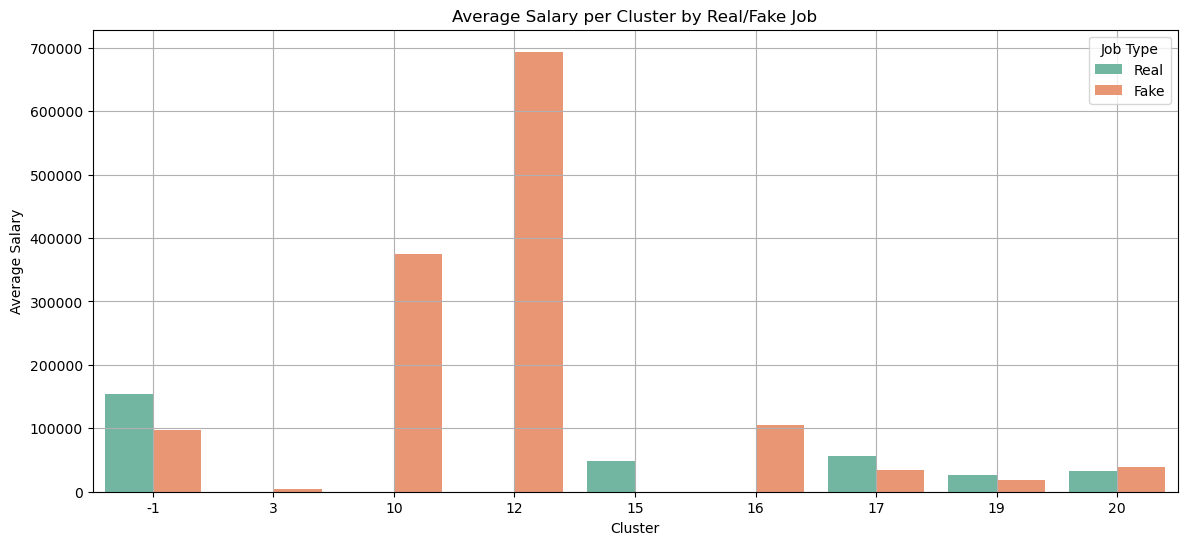

In [ ]:
# group by cluster and fraudulent, then calculate mean salary
avg_salary_by_cluster_and_label = (
    filtered_jobs.groupby(["cluster", "fraudulent"])["salary_range"]
    .mean()
    .reset_index()
)

# replace 0/1 with labels for readability
avg_salary_by_cluster_and_label["fraudulent"] = avg_salary_by_cluster_and_label[  # noqa: E501
    "fraudulent"
].map({0: "Real", 1: "Fake"})

plt.figure(figsize=(14, 6))
sns.barplot(
    data=avg_salary_by_cluster_and_label,
    x="cluster",
    y="salary_range",
    hue="fraudulent",
    palette="Set2",
)
plt.title("Average Salary per Cluster by Real/Fake Job")
plt.xlabel("Cluster")
plt.ylabel("Average Salary")
plt.legend(title="Job Type")
plt.grid(True)
plt.show()

We can see that fake jobs do tend to promise slightly more compared to real jobs in each cluster!